#HW5



1.   Normal approximation for binomial regression model and Bioassay data
2. CH4

 2~3

3. Hierarchical model for Rats experiment
4.   Hierarchical model for SAT-example data

5. CH5

 1~ 6 , 8~15






##1. Normal approximation for binomial regression model and Bioassay data

Overall process is same with demos in ch10,ch11.

The difference is that process is done with approximation, and resampling to show the result

In [1]:
import numpy as np
import pandas as pd
from scipy import optimize, stats

%matplotlib inline
import matplotlib.pyplot as plt

import os, sys
# add utilities directory to path
util_path = os.path.abspath(os.path.join(os.path.pardir, 'utilities_and_data'))
if util_path not in sys.path and os.path.exists(util_path):
    sys.path.insert(0, util_path)

# import from utilities
import plot_tools

# edit default plot settings
plt.rc('font', size=12)
# apply custom background plotting style
plt.style.use(plot_tools.custom_styles['gray_background'])

x = np.array([-0.86, -0.30, -0.05, 0.73])
n = np.array([5, 5, 5, 5])
y = np.array([0, 1, 3, 5])

In [2]:
ngrid = 100
A = np.linspace(-4, 8, ngrid)
B = np.linspace(-10, 40, ngrid)
ilogit_abx = 1 / (np.exp(-(A[:,None] + B[:,None,None] * x)) + 1)
p = np.prod(ilogit_abx**y * (1 - ilogit_abx)**(n - y), axis=2)

In [3]:
# sample from the grid
nsamp = 1000
samp_indices = np.unravel_index(
    np.random.choice(p.size, size=nsamp, p=p.ravel()/np.sum(p)),
    p.shape
)
samp_A = A[samp_indices[1]]
samp_B = B[samp_indices[0]]
# add random jitter, see BDA3 p. 76
samp_A += (np.random.rand(nsamp) - 0.5) * (A[1]-A[0])
samp_B += (np.random.rand(nsamp) - 0.5) * (B[1]-B[0])

# samples of LD50
samp_ld50 = - samp_A / samp_B

In [4]:
# define the optimised function
def bioassayfun(w):
    a = w[0]
    b = w[1]
    et = np.exp(a + b * x)
    z = et / (1 + et)
    e = - np.sum(y * np.log(z) + (n - y) * np.log(1 - z))
    return e
# initial guess
w0 = np.array([0.0, 0.0])
# optimise
optim_res = optimize.minimize(bioassayfun, w0)
# extract desired results
w = optim_res['x']
S = optim_res['hess_inv']

Overhere, implement approximation with calculated w and S above.

In [5]:
A_broadcasted = np.lib.stride_tricks.as_strided(
    A, shape=(ngrid,ngrid), strides=(0, A.strides[0]))
B_broadcasted = np.lib.stride_tricks.as_strided(
    B, shape=(ngrid,ngrid), strides=(B.strides[0], 0))
grid = np.dstack((A_broadcasted, B_broadcasted))
p_norm = stats.multivariate_normal.pdf(x=grid, mean=w, cov=S)

# draw samples from the distribution
samp_norm = stats.multivariate_normal.rvs(mean=w, cov=S, size=1000)

Plot the graphs to show the approximation


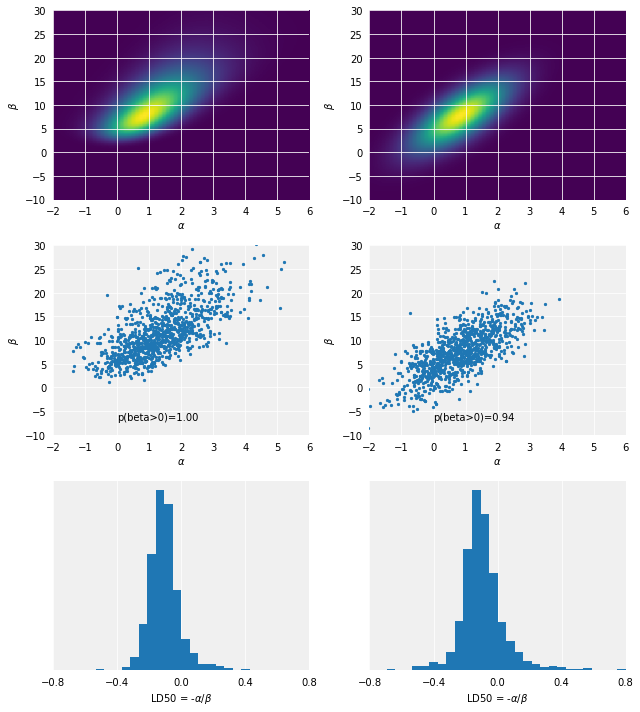

In [6]:
# create figure
fig, axes = plt.subplots(3, 2, figsize=(9, 10))

# plot the posterior density
ax = axes[0, 0]
ax.imshow(
    p,
    origin='lower',
    aspect='auto',
    extent=(A[0], A[-1], B[0], B[-1])
)
ax.set_xlim([-2, 6])
ax.set_ylim([-10, 30])
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\beta$')
ax.grid('off')

# plot the samples
ax = axes[1, 0]
ax.scatter(samp_A, samp_B, 5)
ax.set_xlim([-2, 6])
ax.set_ylim([-10, 30])
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\beta$')
ax.text(0, -7, 'p(beta>0)={:.2f}'.format(np.mean(samp_B>0)))

# plot the histogram of LD50
ax = axes[2, 0]
ax.hist(samp_ld50, np.linspace(-0.8, 0.8, 31))
ax.set_xlim([-0.8, 0.8])
ax.set_xlabel(r'LD50 = -$\alpha/\beta$')
ax.set_yticks(())
ax.set_xticks(np.linspace(-0.8, 0.8, 5))

# plot the posterior density for normal approx.
ax = axes[0, 1]
ax.imshow(
    p_norm,
    origin='lower',
    aspect='auto',
    extent=(A[0], A[-1], B[0], B[-1])
)
ax.set_xlim([-2, 6])
ax.set_ylim([-10, 30])
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\beta$')
ax.grid('off')

# plot the samples from the normal approx.
ax = axes[1, 1]
ax.scatter(samp_norm[:,0], samp_norm[:,1], 5)
ax.set_xlim([-2, 6])
ax.set_ylim([-10, 30])
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\beta$')

# Normal approximation does not take into account that the posterior
# is not symmetric and that there is very low density for negative
# beta values. Based on the samples from the normal approximation
# it is estimated that there is about 4% probability that beta is negative!
ax.text(0, -7, 'p(beta>0)={:.2f}'.format(np.mean(samp_norm[:,1]>0)))

# Plot the histogram of LD50
ax = axes[2, 1]
# Since we have strong prior belief that beta should not be negative we can
# improve our normal approximation by conditioning on beta>0.
bpi = samp_norm[:,1] > 0
samp_ld50_norm = - samp_norm[bpi,0] / samp_norm[bpi,1]
ax.hist(samp_ld50_norm, np.linspace(-0.8, 0.8, 31))
ax.set_xlim([-0.8, 0.8])
ax.set_xlabel(r'LD50 = -$\alpha/\beta$')
ax.set_yticks(())
ax.set_xticks(np.linspace(-0.8, 0.8, 5))

fig.tight_layout()

## 2.CH4-2,3

###2-1. CH4-3

Let $\theta = -\frac{\alpha}{\beta}$

By taylor seriex expansion, If we can find posterior mode that satisfy $\frac{d}{d \theta} log p(\theta| \mathcal{D} ) =0$, the below works

$log p(\theta | \mathcal{D} ) \sim logp(\hat{\theta} | \mathcal{D} ) + \frac{1}{2} (\theta - \hat{\theta})^2 \left[ \frac{d^2}{d \theta^2} logp (\theta | \mathcal{D} \right] _{\theta= \hat{\theta}} $

Therefore, $ \theta | \mathcal{D} \sim N(\hat{\theta} , I(\hat{\theta})^{-1})$


To find a mode, implement variable transformation

$\theta = -\frac{\alpha}{\beta} $ , $\nu = \beta$ 

which is : $\alpha = -\theta \nu $,  $\beta = \nu$ 

Jacobian is

$J = \left| \frac{\partial(\alpha, \beta)}{\partial (\nu, \theta) }\right| = \nu$

therefore,

$p(\theta|y) = \int p(\theta,\nu |y)d \nu = \int p(\alpha, \beta|y) |\nu| d\nu $ = $\int p(\alpha, \beta |y) |\beta| d\beta$

In [56]:
ilogit_abxx = 1 / (np.exp(-(samp_norm[:,0][:,None] + samp_norm[:,1][:,None,None] * x)) + 1)
pp = np.prod(ilogit_abxx**y * (1 - ilogit_abxx)**(n - y), axis=2)
ppp=np.mean(pp*np.abs(samp_norm[:,1]),axis=0)

samp_indices = np.unravel_index(
    np.random.choice(ppp.size, size=10000, p=ppp/np.sum(ppp)),
    ppp.shape
)

ld = -samp_norm[:,0]/samp_norm[:,1]
samp= ld[samp_indices]


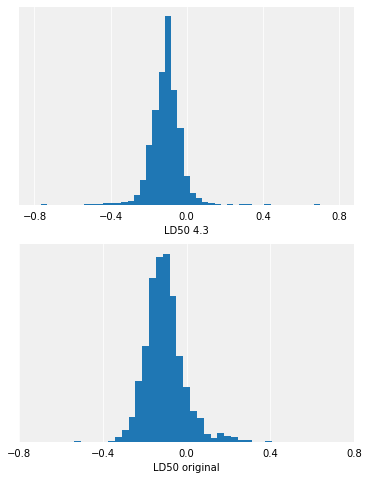

In [59]:
# create figure
fig, axes = plt.subplots(2, 1, figsize=(6, 8))

ax = axes[0]
ax.hist(samp,  np.linspace(-0.8, 0.8,50))
ax.set_xlabel('LD50 4.3')
ax.set_yticks(())
ax.set_xticks(np.linspace(-0.8, 0.8, 5))

ax = axes[1]
ax.hist(samp_ld50, np.linspace(-0.8, 0.8,50))
ax.set_xlim([-0.8, 0.8])
ax.set_xlabel('LD50 original')
ax.set_xticks(np.linspace(-0.8, 0.8, 5))
ax.set_yticks(())


plt.show()

Graph are similar. The one from 4.3. is little bit concentrated.


### CH4.2

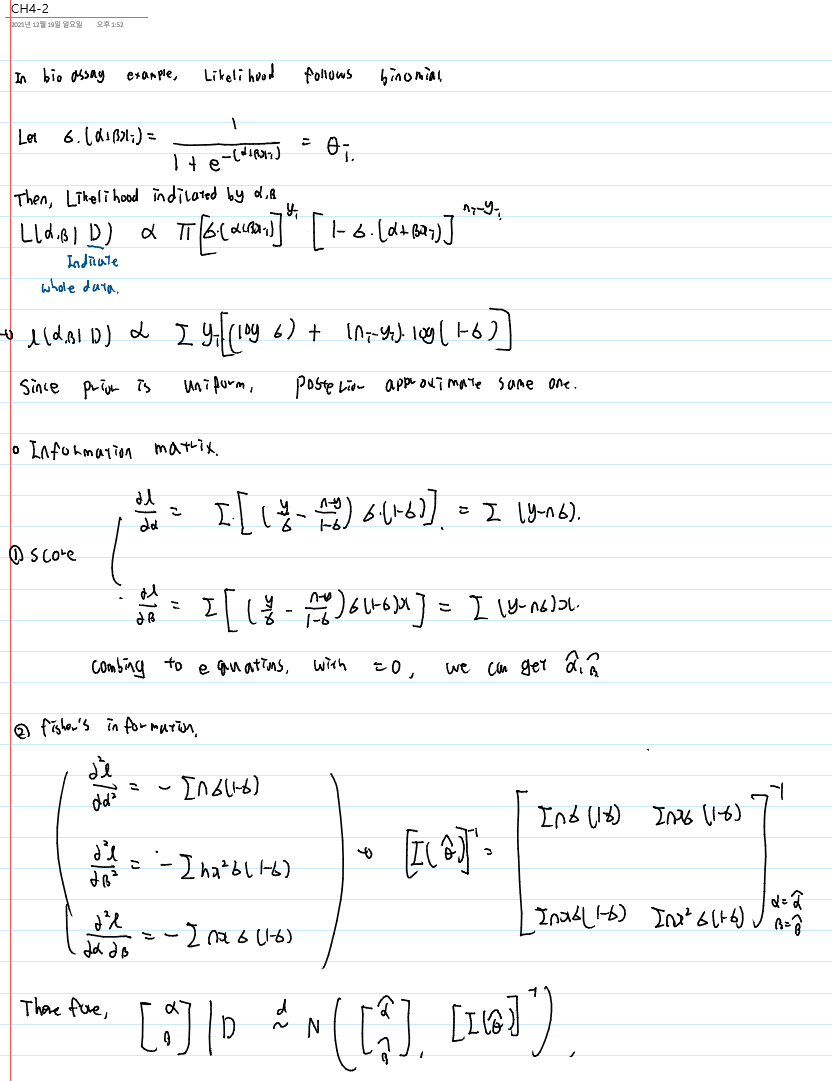

##3.  Hierarchical model for Rats experiment

Code from https://github.com/avehtari/BDA_py_demos/blob/master/demos_ch5/demo5_1.ipynb



For rats example in the book, it follows like

$\mathcal{D} = $ ${(n_i ,y_i  )}_{i=1} ^{71}$

For each experiment, $y_i$ ~ $Binom(n_i, \theta_i )$, which means that there are 71 different $\theta$, drawn from common distribution $p(\theta| \alpha,\beta)$

In [ ]:
from scipy.stats import beta
from scipy.special import gammaln

#data to be used
y = np.array([
     0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,
     1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  1,  5,  2,
     5,  3,  2,  7,  7,  3,  3,  2,  9, 10,  4,  4,  4,  4,  4,  4,  4,
    10,  4,  4,  4,  5, 11, 12,  5,  5,  6,  5,  6,  6,  6,  6, 16, 15,
    15,  9,  4
])
n = np.array([
    20, 20, 20, 20, 20, 20, 20, 19, 19, 19, 19, 18, 18, 17, 20, 20, 20,
    20, 19, 19, 18, 18, 25, 24, 23, 20, 20, 20, 20, 20, 20, 10, 49, 19,
    46, 27, 17, 49, 47, 20, 20, 13, 48, 50, 20, 20, 20, 20, 20, 20, 20,
    48, 19, 19, 19, 22, 46, 49, 20, 20, 23, 19, 22, 20, 20, 20, 52, 46,
    47, 24, 14
])
M = len(y)

At first, The book implemented the simple model without hyperparameter 

: It does not make full bayesian model, instead, don't use any information (separate model) or just use the information previous(pooled model)

Separate model 

for each of $\theta_i$, assume we have p($\theta_i$)  = dbeta(1,1) and derive posterior $p(\theta_i |y_i) = dbeta(y_i+1 ,n_i-y_i +1 )$

Text(0.5, 1.0, 'separate model')

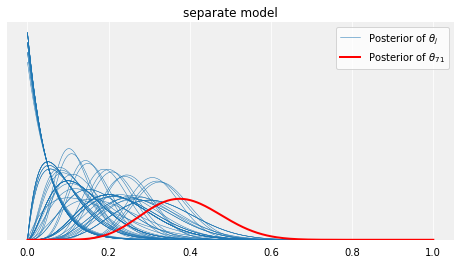

In [ ]:
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8, 4))
x = np.linspace(0, 1, 250)

# separate
ax = axes
lines = ax.plot(
    x,
    beta.pdf(x[:,None], y[:-1] + 1, n[:-1] - y[:-1] + 1),
    color='C0',
    linewidth=0.5
)
# highlight the last line
lines[-1].set_linewidth(2)
lines[-1].set_color('r')
ax.legend(
    (lines[0], lines[-1]),
    (r'Posterior of $\theta_j$',
     r'Posterior of $\theta_{71}$')
)
ax.set_ylim((0, ax.set_ylim()[1]))  # set y base to zero
ax.set_yticks(())
ax.set_title('separate model')


Pooled model

ignore the subscripts, act as if they all came from same dist.

$p(\theta |y) ~ dbeta(1+ \sum y_i , 1+ \sum(n_i-y_i) $)

Text(0.5, 1.0, 'pooled model')

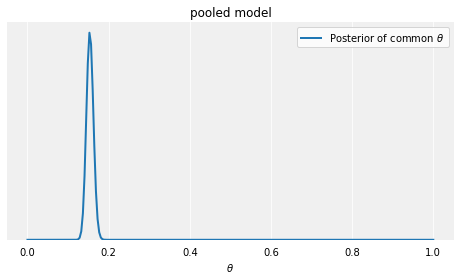

In [ ]:

fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8, 4))
x = np.linspace(0, 1, 250)

ax = axes
ax.plot(
    x,
    beta.pdf(x, y.sum() + 1, n.sum() - y.sum() + 1),
    linewidth=2,
    label=(r'Posterior of common $\theta$')
)
ax.legend()
ax.set_ylim((0, ax.set_ylim()[1]))  # set y base to zero
ax.set_yticks(())
ax.set_xlabel(r'$\theta$')
ax.set_title('pooled model')


Now, we use hierarchical model to accept the idea that parameters are correlated in some point:

Hierarchical model with hyperparameter

we use the prior 

$p(\alpha, \beta) \propto (\alpha+ \beta) ^{-5/2}$

The reason for using it will be proved at Exercise 5-9

With this prior, marginal posterior calculated in class is:

$log p(\alpha, \beta | \mathcal{D}) = -\frac{5}{2} log(\alpha+ \beta) +J(log \Gamma (\alpha + \beta) -log \Gamma (\alpha) -log \Gamma (\beta) + \sum[ log \Gamma (\alpha + y_i ) + log \Gamma (\beta + n_j -y_j) -log \Gamma (\alpha +\beta +n_j ) $

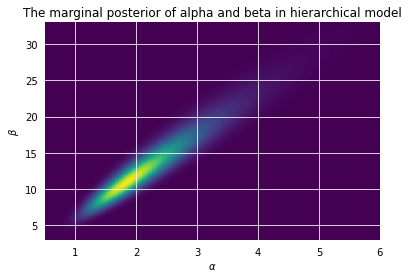

In [ ]:
# compute the marginal posterior of alpha and beta in the hierarchical model in a grid
A = np.linspace(0.5, 6, 100)
B = np.linspace(3, 33, 100)
# calculated in logarithms for numerical accuracy
lp = (
  - 5/2 * np.log(A + B[:,None])
  + np.sum(
        gammaln(A + B[:,None])
      - gammaln(A)
      - gammaln(B[:,None])
      + gammaln(A + y[:,None,None])
      + gammaln(B[:,None] + (n - y)[:,None,None])
      - gammaln(A + B[:,None] + n[:,None,None]),
        axis=0
    )
)
# subtract the maximum value to avoid over/underflow in exponentation
lp -= lp.max()
p = np.exp(lp)

# plot the marginal posterior
plt.imshow(
    p,
    origin='lower',
    aspect='auto',
    extent=(A[0], A[-1], B[0], B[-1])
)
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\beta$')
plt.title('The marginal posterior of alpha and beta in hierarchical model')
plt.grid('off')

From the above marginal posterior distribution ,sample $\theta_j$ .

With these, we can approximate the marginal distribution for $\theta$

: $p(\theta|\mathcal{D} ) = \int \int p(\theta| \alpha, \beta ,\mathcal{D}) p(\alpha, \beta |\mathcal{D} ) d \alpha d \beta $ 

Which can be approximated by mean of sample distributions

In [ ]:
# sample from the posterior grid of alpha and beta
nsamp = 1000
samp_indices = np.unravel_index(
    np.random.choice(p.size, size=nsamp, p=p.ravel()/p.sum()),
    p.shape
)
samp_A = A[samp_indices[1]]
samp_B = B[samp_indices[0]]
# add random jitter, see BDA3 p. 76
samp_A += (np.random.rand(nsamp) - 0.5) * (A[1]-A[0])
samp_B += (np.random.rand(nsamp) - 0.5) * (B[1]-B[0])

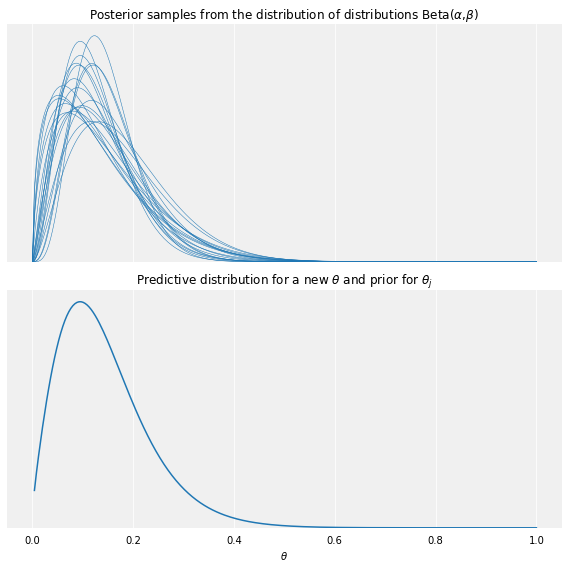

In [ ]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(8, 8))

# Plot samples from the distribution of distributions Beta(alpha,beta),
# that is, plot Beta(alpha,beta) using the posterior samples of alpha and beta
ax = axes[0]
ax.plot(
    x,
    beta.pdf(x[:,None], samp_A[:20], samp_B[:20]),
    linewidth=0.5,
    color='C0'
)
ax.set_yticks(())
ax.set_title(
    r'Posterior samples from the distribution of distributions '
    r'Beta($\alpha$,$\beta$)'
)
ax.set_ylim((0, ax.set_ylim()[1]))  # set y base to zero

# The average of above distributions, is the predictive distribution for a new
# theta, and also the prior distribution for theta_j.
# Plot this.
ax = axes[1]
plt.plot(x, np.mean(beta.pdf(x, samp_A[:,None], samp_B[:,None]), axis=0))
ax.set_yticks(())
ax.set_xlabel(r'$\theta$')
ax.set_title(
    r'Predictive distribution for a new $\theta$ '
    r'and prior for $\theta_j$'
)
ax.set_ylim((0, ax.set_ylim()[1]))  # set y base to zero

fig.tight_layout()

Finally, compare the results from seperate model and hierarchical model

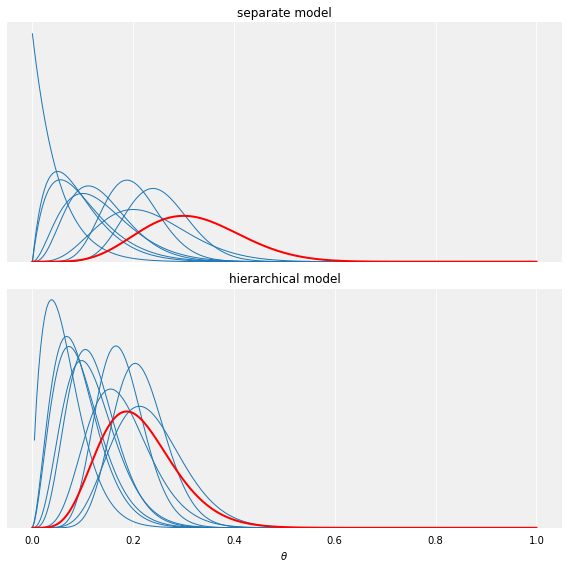

In [ ]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(8, 8))
x = np.linspace(0, 1, 250)

# first plot the separate model (same as above)
ax = axes[0]
# note that for clarity only every 7th distribution is plotted
lines = ax.plot(
    x,
    beta.pdf(x[:,None], y[7:-1:7] + 1, n[7:-1:7] - y[7:-1:7] + 1),
    color='C0',
    linewidth=1
)
# highlight the last line
lines[-1].set_linewidth(2)
lines[-1].set_color('r')
ax.set_yticks(())
ax.set_title('separate model')
ax.set_ylim((0, ax.set_ylim()[1]))  # set y base to zero

# And the hierarchical model. Note that these marginal posteriors for theta_j are
# more narrow than in the separate model case, due to the borrowed information from
# the other theta_j's.
ax = axes[1]
# note that for clarity only every 7th distribution is plotted
lines = ax.plot(
    x,
    np.mean(
        beta.pdf(
            x[:,None],
            y[7::7] + samp_A[:,None,None],
            n[7::7] - y[7::7] + samp_B[:,None,None]
        ),
        axis=0
    ),
    color='C0',
    linewidth=1,
)
# highlight the last line
lines[-1].set_linewidth(2)
lines[-1].set_color('r')
ax.set_yticks(())
ax.set_xlabel(r'$\theta$')
ax.set_title('hierarchical model')
ax.set_ylim((0, ax.set_ylim()[1]))  # set y base to zero

fig.tight_layout()

## 4.Hierarchical model for SAT-example data

Code referenced to https://github.com/avehtari/BDA_py_demos/blob/master/demos_ch5/demo5_2.ipynb

Lower level & higher level follows normal:

$ \bar{y_j}  \sim N(\theta_j , \sigma_j ^2) $, $\sigma_j known$

$\theta_j \sim N(\mu, \tau^2 ) $ , $\mu, \tau$ are hyperparameters

$p(\mu |\tau) = p(\mu|\tau) p(\tau) $


$\bar{y_j} $ and $ \sigma_j^2 $ are suggested as below

In [ ]:
from scipy.stats import norm
y = np.array([28,  8, -3,  7, -1,  1, 18, 12])
s = np.array([15, 10, 16, 11,  9, 11, 10, 18])
M = len(y)

In [ ]:
#pre-computed data given in official site
hres = np.load('demo5_2.npz')
''' Content information of the precalculated results:
name  shape      dtype
------------------------
pxm   (8, 500)   float64
t     (1000,)    float64
tp    (1000,)    float64
tsd   (8, 1000)  float64
tm    (8, 1000)  float64
'''
pxm = hres['pxm']
t   = hres['t']
tp  = hres['tp']
tsd = hres['tsd']
tm  = hres['tm']
hres.close()

Approximate seperate and pooled ones

* pooled model follow distribution such as:

$\bar{y}  $ ~ $N \left( (\sum_j \frac{\bar{y}_j}{\sigma_j ^2}) (\sum_j \frac{1}{\sigma_j ^2})^{-1} ,  (\sum_j \frac{1}{\sigma_j^2 } )^{-1} \right)$

(0.0, 0.10287242240535246)

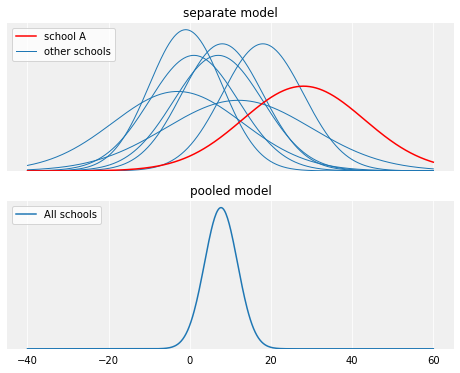

In [ ]:
# plot the separate, pooled and hierarchical models
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(8, 6))
x = np.linspace(-40, 60, 500)

# separate
ax = axes[0]
lines = ax.plot(
    x,
    norm.pdf(x[:,None], y[1:], s[1:]),
    color='C0',
    linewidth=1
)
line, = ax.plot(x, norm.pdf(x, y[0], s[0]), color='red')
ax.legend(
    (line, lines[0]),
    ('school A', 'other schools'),
    loc='upper left'
)
ax.set_yticks(())
ax.set_title('separate model')
ax.set_ylim((0, ax.set_ylim()[1]))  # set y base to zero

# pooled
ax = axes[1]
ax.plot(
    x,
    norm.pdf(
        x,
        np.sum(y/s**2)/np.sum(1/s**2),
        np.sqrt(1/np.sum(1/s**2))
    ),
    label='All schools'
)
ax.legend(loc='upper left')
ax.set_yticks(())
ax.set_title('pooled model')
ax.set_ylim((0, ax.set_ylim()[1]))  # set y base to zero

For hierarchical model, it's using pre-calculated result. 

However, the process looks like:

1. generate $\tau$ from $p(\tau |y) $

2. generate $\mu$ from $p(\mu |\tau, y) $ 

3. generate $\theta_j$ fomr $p(\theta|\mu,\tau,y )$

4. generate $\bar{y} from N(y|\theta_j, \sigma_j ^2 )$


Equation for each steps are suggested in lecture

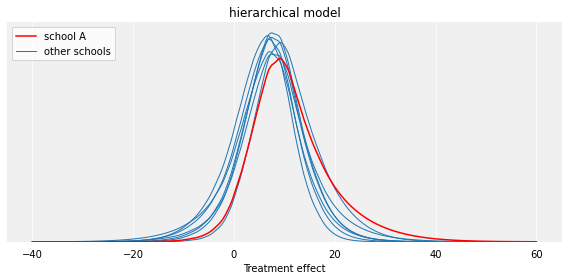

In [ ]:
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8, 4))
x = np.linspace(-40, 60, 500)

ax = axes
lines = ax.plot(x, pxm[1:].T, color='C0',linewidth=1)
line, = ax.plot(x, pxm[0], color='red')
ax.legend(
    (line, lines[0]),
    ('school A', 'other schools'),
    loc='upper left'
)
ax.set_yticks(())
ax.set_title('hierarchical model')
ax.set_xlabel('Treatment effect')
ax.set_ylim((0, ax.set_ylim()[1]))  # set y base to zero

fig.tight_layout()

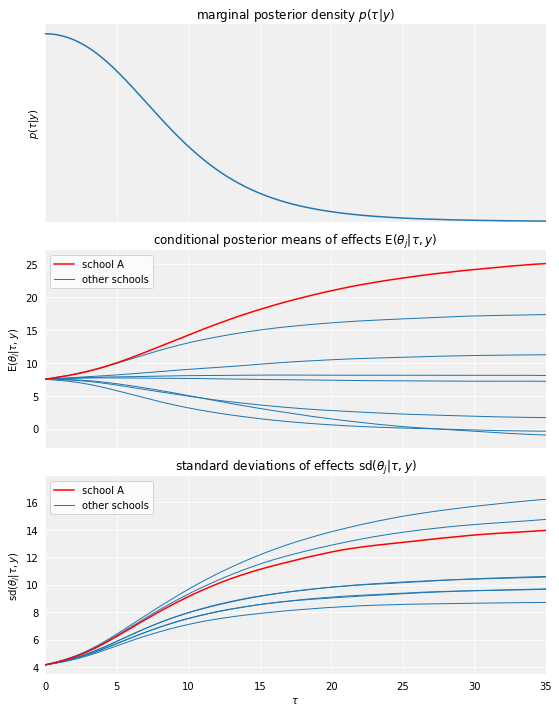

In [ ]:
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(8,10))

axes[0].plot(t, tp)
axes[0].set_yticks(())
axes[0].set_title(r'marginal posterior density $p(\tau|y)$')
axes[0].set_ylabel(r'$p(\tau|y)$')
axes[0].set_xlim([0, 35])
axes[0].set_ylim([0, axes[0].set_ylim()[1]])

lines = axes[1].plot(t, tm[1:].T, color='C0', linewidth=1)
line, = axes[1].plot(t, tm[0].T, color='red')
axes[1].legend(
    (line, lines[1]),
    ('school A', 'other schools'),
    loc='upper left'
)
axes[1].set_title(r'conditional posterior means of effects '
                  r'$\operatorname{E}(\theta_j|\tau,y)$')
axes[1].set_ylabel(r'$\operatorname{E}(\theta_j|\tau,y)$')

lines = axes[2].plot(t, tsd[1:].T, color='C0', linewidth=1)
line, = axes[2].plot(t, tsd[0].T, color='red')
axes[2].legend(
    (line, lines[1]),
    ('school A', 'other schools'),
    loc='upper left'
)
axes[2].set_title(r'standard deviations of effects '
                  r'$\operatorname{sd}(\theta_j|\tau,y)$')
axes[2].set_ylabel(r'$\operatorname{sd}(\theta_j|\tau,y)$')
axes[2].set_xlabel(r'$\tau$')

fig.tight_layout()

## 5. CH5

### CH5 - 1 

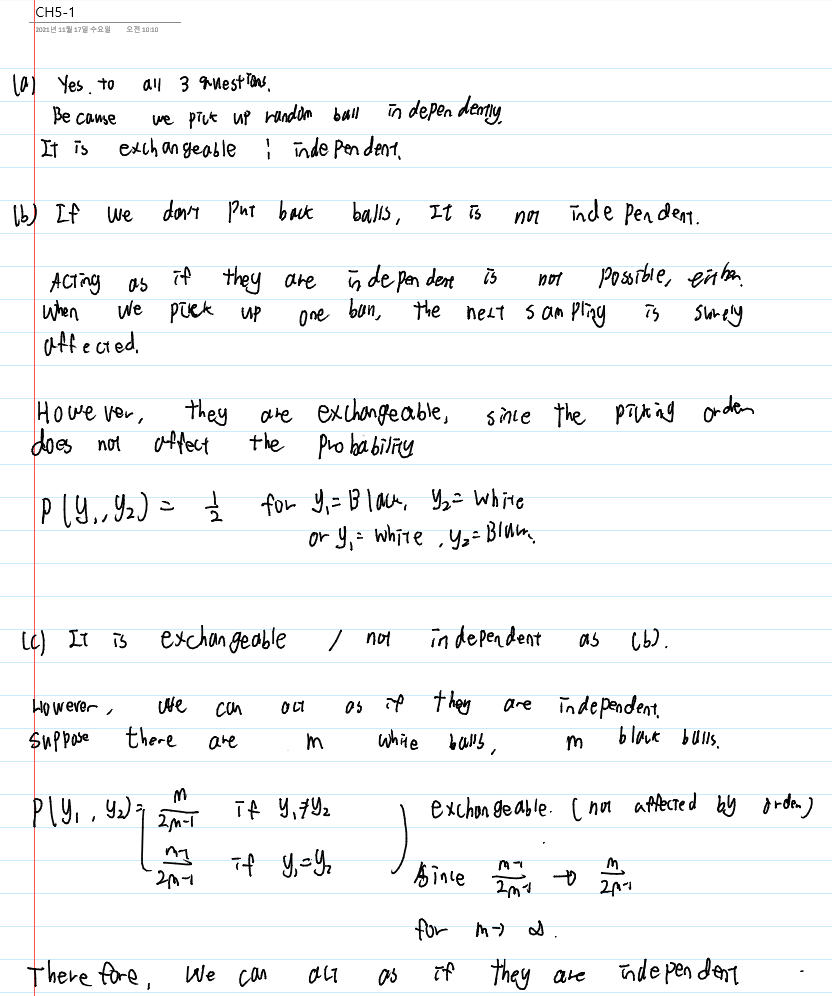

### CH5 - 2 

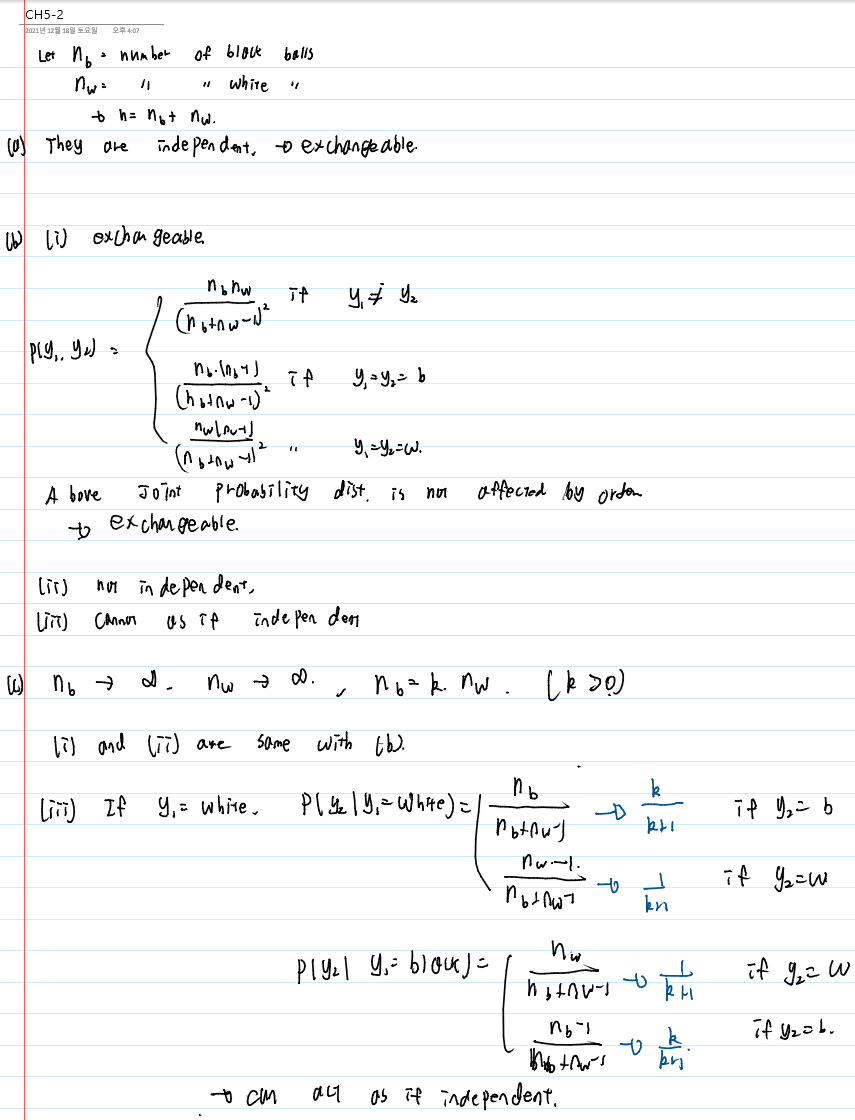

### CH5 - 3

(a) 

generate 1000 samples of y for each school(1,2,3,...,8)

Then, calculate the result

In [ ]:
nsamp = 1000
samp_pxm={}
for i in np.arange(8):
  samp_indices = np.unravel_index(
    np.random.choice(pxm[i].size, size = nsamp, p = pxm[i].ravel()/pxm[i].sum()),
    pxm.shape
  )
  samp_pxm[f'samp_pxm{i+1}'] = pxm[i][samp_indices[1]]
samp_pxm_df = pd.DataFrame(samp_pxm)

In [ ]:
chart = pd.DataFrame(columns = ['pr(best)',1,2,3,4,5,6,7,8], index = [1,2,3,4,5,6,7,8])

In [ ]:
for i in range(8):
  num = 0
  for j in range(1000):
    if samp_pxm_df.loc[j][i] == max(samp_pxm_df.loc[j]):
      num = num+1
    else:
      num = num
  chart['pr(best)'][i+1] = num/1000
  for k in [1,2,3,4,5,6,7,8]:
    num=0
    for j in range(1000):
      if samp_pxm_df.loc[j][i] <= samp_pxm_df.loc[j][k-1]:
        num = num+1
      else:
        num = num
    chart[i+1][k] = num/1000

chart

,pr(best),1,2,3,4,5,6,7,8
1,0.021,1,0.35,0.428,0.36,0.375,0.386,0.387,0.431
2,0.256,0.65,1,0.606,0.526,0.52,0.547,0.557,0.59
3,0.045,0.572,0.394,1,0.402,0.41,0.445,0.435,0.504
4,0.219,0.64,0.474,0.598,1,0.518,0.545,0.542,0.607
5,0.175,0.625,0.48,0.59,0.482,1,0.532,0.536,0.6
6,0.128,0.614,0.453,0.555,0.455,0.468,1,0.504,0.568
7,0.109,0.613,0.443,0.565,0.458,0.464,0.496,1,0.564
8,0.047,0.569,0.41,0.496,0.393,0.4,0.432,0.436,1


result is different with book because of order difference
(I referenced the code from site, but it didn't say about order. so I couldn't figure out which one is A or which one is B. 

However, overall result is similar with book

(b)

$\theta_j |y \sim N(y_j, \sigma_j ^2) $

$ pr(\theta_i >\theta_j |y ) = \Phi (\frac{y_i -y_j}{\sqrt{\sigma_i ^2 + \sigma_j^2} })$

$pr(\theta_i $  is largest $ ) = \int ^\infty _\infty \Pi_{j \neq i} \Phi \left( \frac{\theta_i -y_j}{\sigma_j} \right)  \phi(\theta_i |y_i, \sigma_i ) d\theta_i$

In [ ]:
def largest(i):
  li = [0,1,2,3,4,5,6,7]
  del li[i]
  sum=np.ones(10000)
  theta = np.random.normal(y[i],s[i],10000)
  for j in li:
    sum = sum * (norm.cdf((theta  -y[j])/s[j])) 
  return np.mean(sum)

In [ ]:
chart = pd.DataFrame(columns = ['pr(best)',1,2,3,4,5,6,7,8], index = [1,2,3,4,5,6,7,8])
for i in range(8):
  chart['pr(best)'][i+1] = np.round(largest(i),3)
  li = [0,1,2,3,4,5,6,7]
  del li[i]
  for k in li:
    chart[k+1][i+1] = np.round(norm.cdf((y[i]-y[k])/np.sqrt(s[i]**2+s[k]**2)),3)

chart

,pr(best),1,2,3,4,5,6,7,8
1,0.548,NaN,0.866,0.921,0.871,0.951,0.927,0.71,0.753
2,0.035,0.134,NaN,0.72,0.527,0.748,0.681,0.24,0.423
3,0.026,0.079,0.28,NaN,0.303,0.457,0.418,0.133,0.267
4,0.036,0.129,0.473,0.697,NaN,0.713,0.65,0.23,0.406
5,0.004,0.049,0.252,0.543,0.287,NaN,0.444,0.079,0.259
6,0.013,0.073,0.319,0.582,0.35,0.556,NaN,0.126,0.301
7,0.168,0.29,0.76,0.867,0.77,0.921,0.874,NaN,0.615
8,0.17,0.247,0.577,0.733,0.594,0.741,0.699,0.385,NaN


(c) if  $ \tau = \infty$ , the values are extreme

(d) if $\tau=0$, all of the school effects are same.

### CH5-5

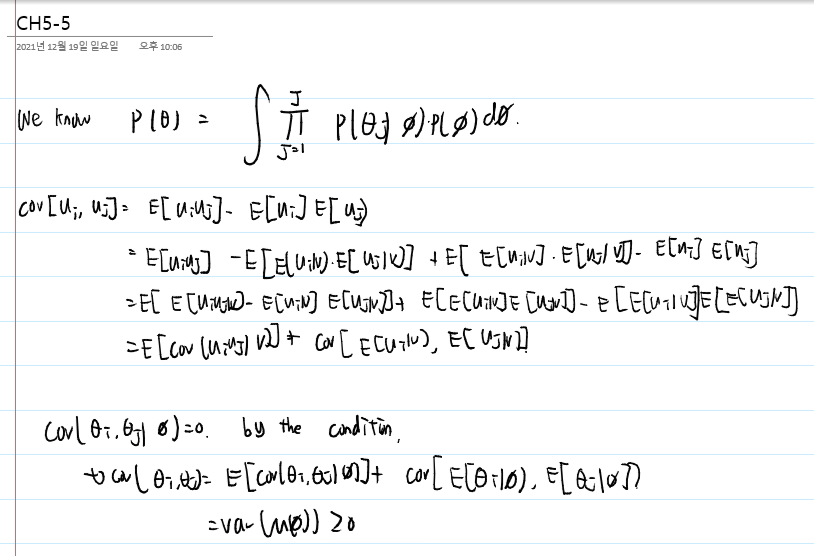

### CH5-4

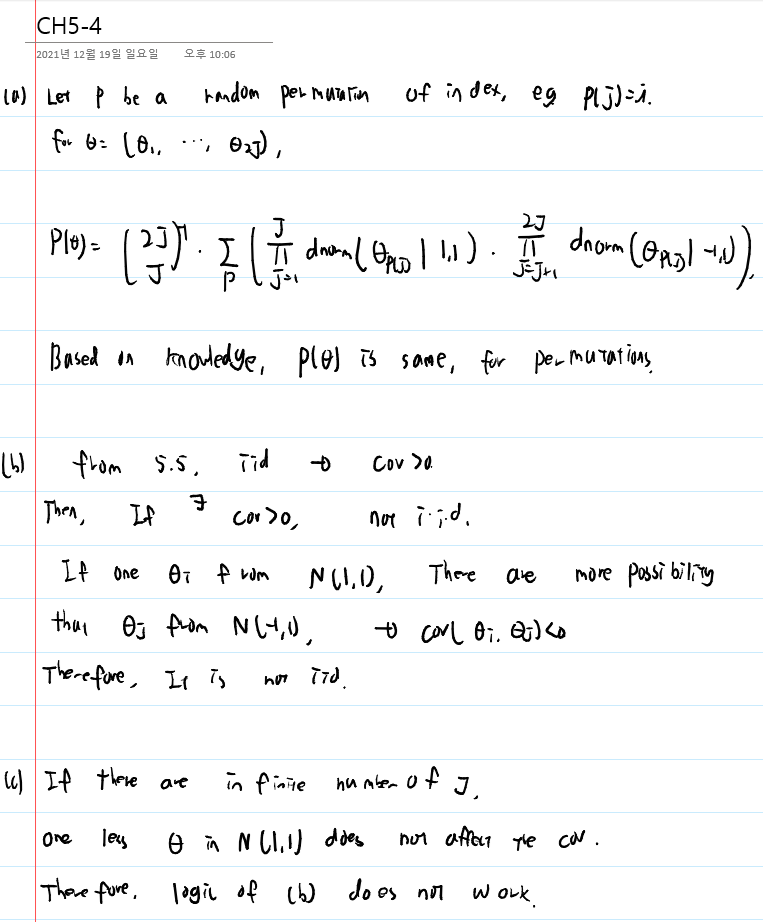

### CH5-7

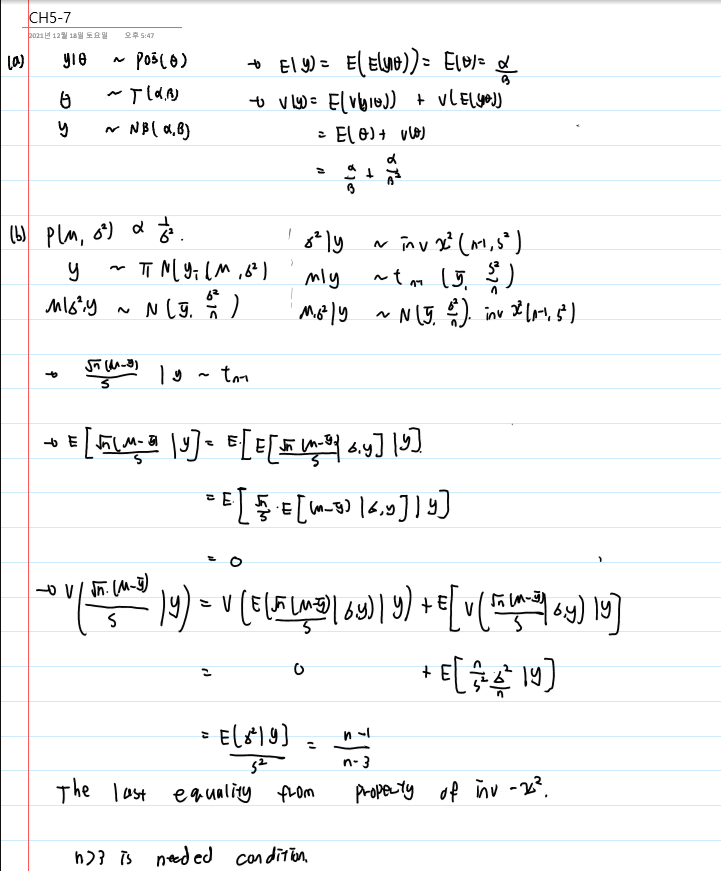

### CH5-8

By bayes thoerem,

$p(\theta | y) \propto \sum_m \lambda_m p_m (\theta)p(y|\theta) = \sum_m \lambda_m p_m(y)p_m(\theta|y) $

It is the weighted average of each conjugate posterior. 

Since each prior is conjugate, we can find conjugate prior corresponding to mixedconjugate prior

### CH5-9

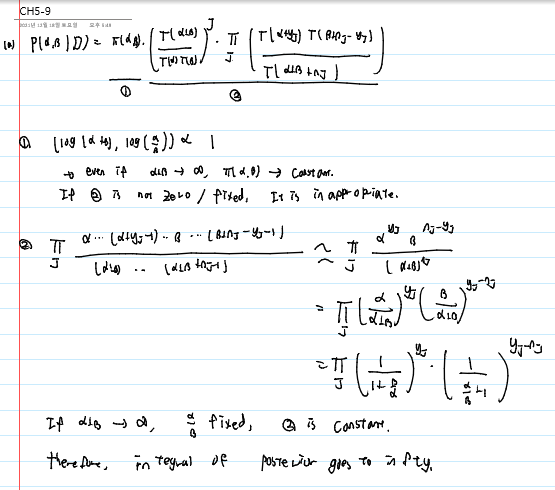

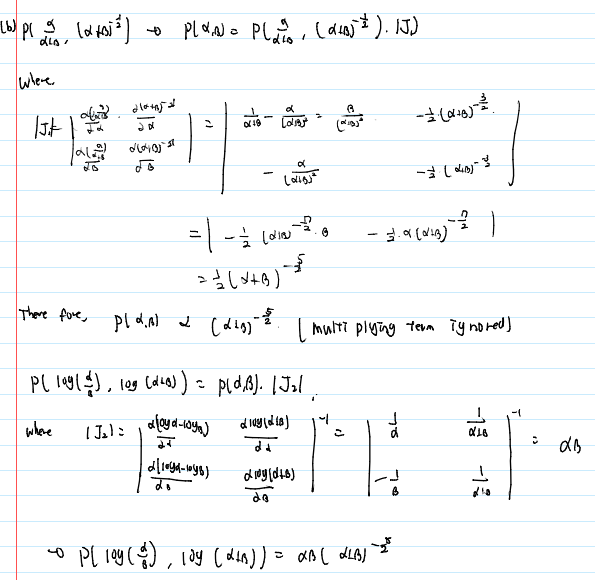

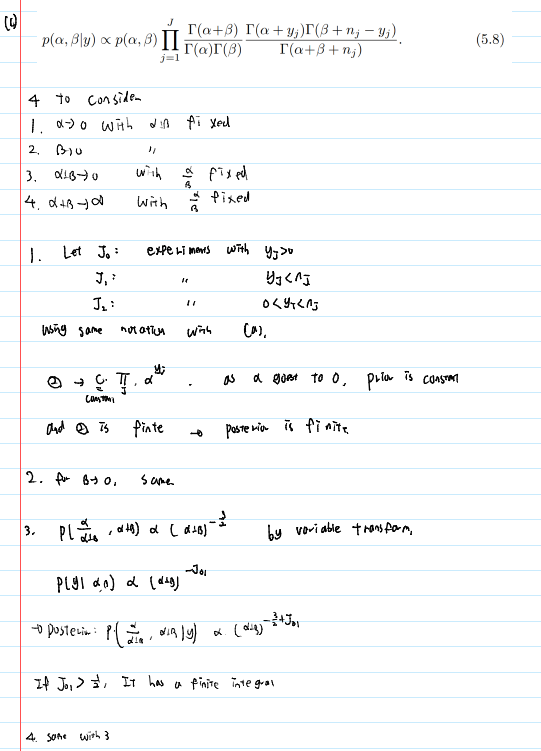

### CH5-10

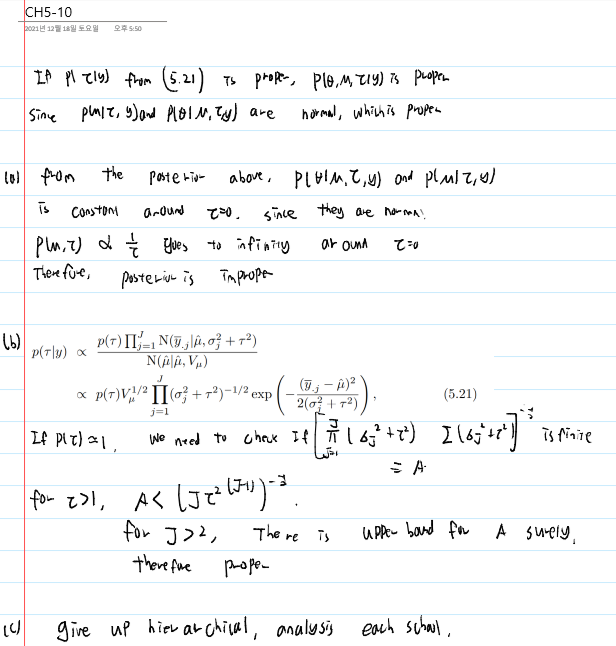

###CH5-11

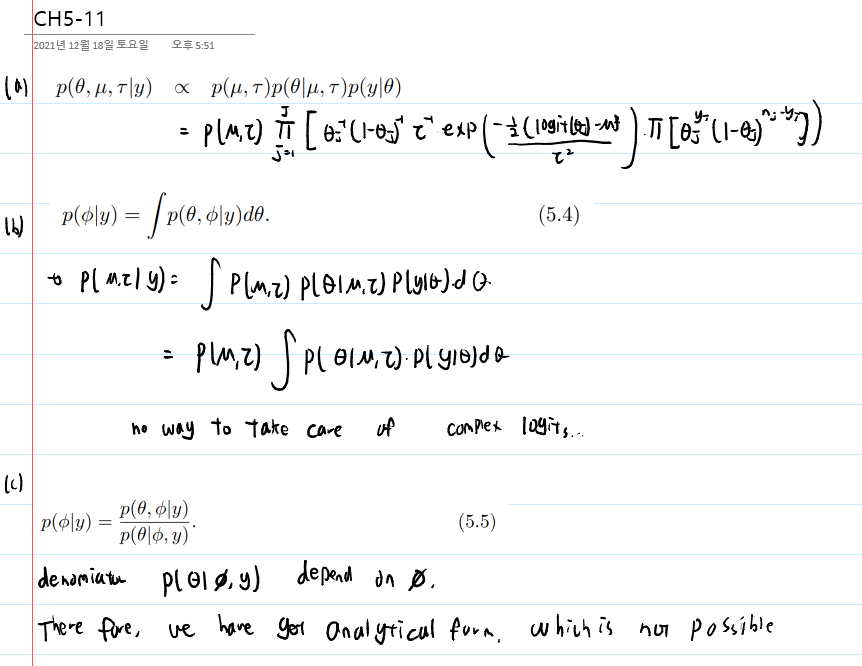

### CH5-12

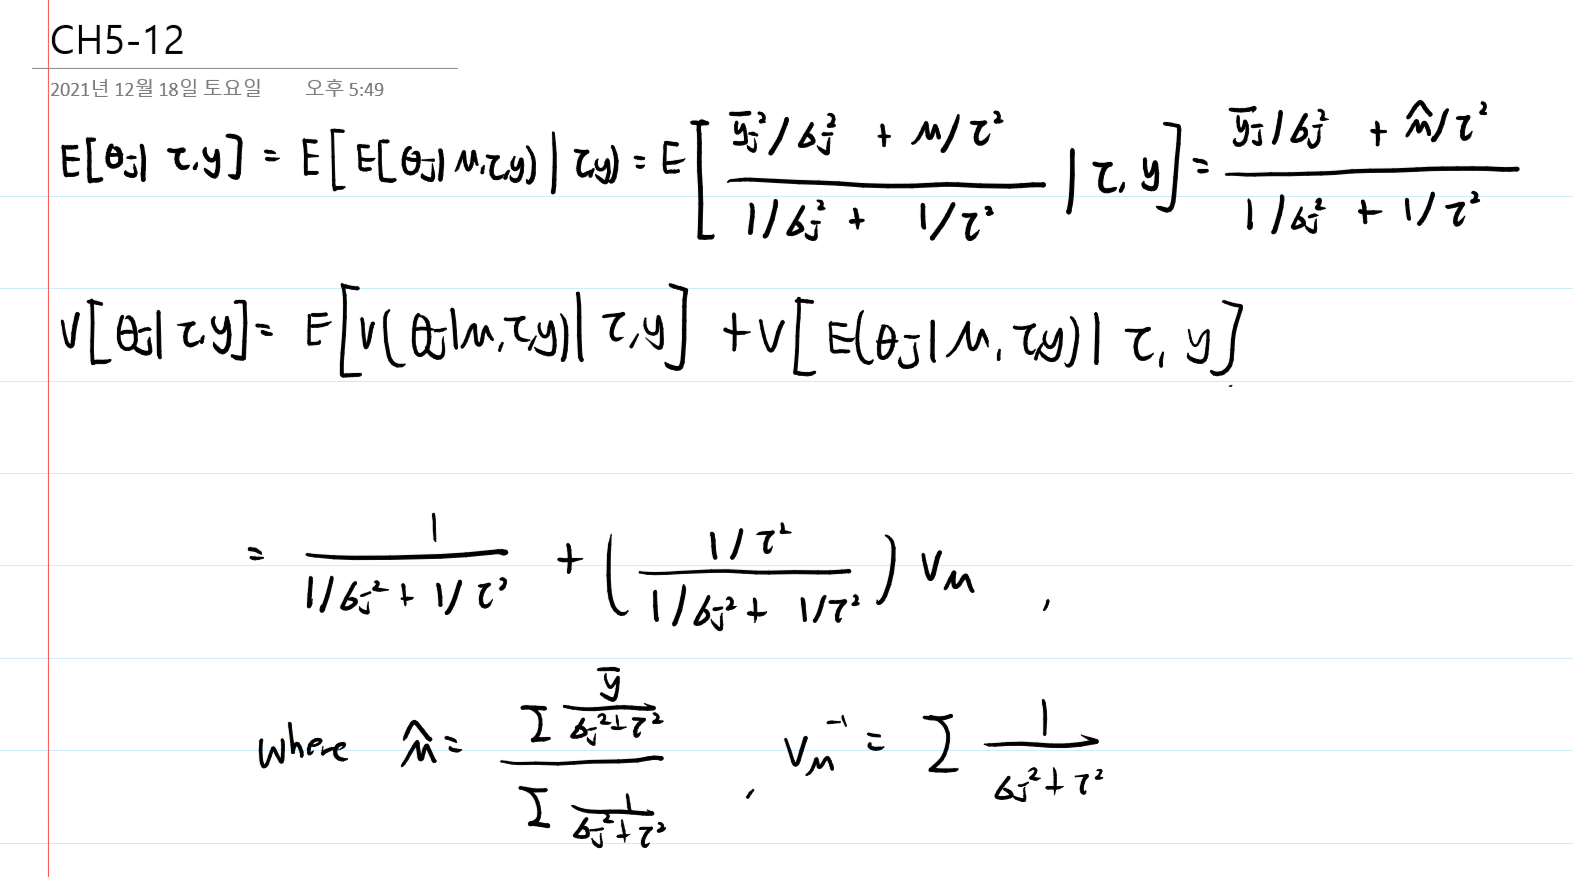